# STAT5243 Project 4: Causal Inference

**Group 2:**

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

## Exploring the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')

In [3]:
highDim_dataset.shape

(2000, 187)

In [4]:
highDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


In [5]:
lowDim_dataset.shape

(500, 24)

In [6]:
lowDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


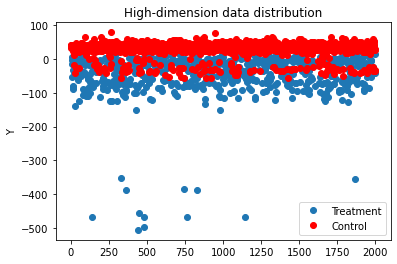

In [7]:
plt.plot(highDim_dataset[highDim_dataset.A == 1].Y, 'o', label="Treatment")
plt.plot(highDim_dataset[highDim_dataset.A == 0].Y, 'ro', label="Control")
plt.title("High-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

plt.plot(lowDim_dataset[lowDim_dataset.A == 1].Y, 'o', label='Treatment')
plt.plot(lowDim_dataset[lowDim_dataset.A == 0].Y, 'ro', label = 'Control')
plt.title("Low-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

## Native ATE

In [8]:
def ATE(dataset):
    return dataset[dataset["A"] == 1]["Y"].mean() - dataset[dataset["A"] == 0]["Y"].mean()
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [9]:
ATE(highDim_dataset)

-75.17133436876794

In [10]:
ATE(lowDim_dataset)

10.60206866191568

## Propensity score - boosted stumps (GBM)

**High Dim no weight**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
def my_train_test_split(dataset):
    X = dataset.drop(['Y', 'A'], axis=1)
    A = dataset['A']
    X_train, X_test, A_train, A_test = train_test_split(X, A, test_size=0.2, random_state=42)
    return X_train, X_test, A_train, A_test

**Grid search**

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
param_grid = {
              'learning_rate': [0.05, 0.01],
              'max_depth': [3, 5],
              'min_samples_split': [2,],
              'n_estimators': [100],
              'min_samples_leaf': [1, 3]
              }

In [15]:
def grid_search(X, A, model, param_grid=param_grid, cv=5, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    
    Inputs:
    -------
    X: feature set for fitting the model
    y: target for predictions
    model: an sklearn estimator object
    param_grid: dict, a dictionary that contains possible search values for parameters
    print_step: bool, whether to print detailed scores for each combination of parameters;
                set print_step=False to only report the best combination of parameters and the best scores
    sample_weight:np.array, instance weights, optional
    
    
    Output:
    -------
    The sklearn estimator object with hyperparameters set to be the best parameters from search 
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        		print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

**High Dim no weight**

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
X_train, X_test, A_train, A_test = my_train_test_split(highDim_dataset)

In [18]:
# gbm_high_no_weight = grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=0), sample_weight=None)

In [19]:
# Best params from grid search
# best_params_high_no_weight = {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

# Emperical best params
best_params_high_no_weight = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
gbm_high_no_weight = GradientBoostingClassifier(random_state=0).set_params(**best_params_high_no_weight)
clf = gbm_high_no_weight.fit(X_train, A_train, sample_weight=None)
clf.score(X_test, A_test)

0.7325

In [20]:
X = highDim_dataset.drop(['Y', 'A'], axis=1)
ps_highDim_dataset_no_weight = clf.predict_proba(X)[:, 1]
ps_highDim_dataset_no_weight

array([0.31110791, 0.27882681, 0.24175831, ..., 0.32230458, 0.44546939,
       0.23874014])

**Low Dim no weight**

In [21]:
X_train, X_test, A_train, A_test = my_train_test_split(lowDim_dataset)

In [22]:
gbm_low_no_weight = grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=0), sample_weight=None)

Best accuracy: 0.790

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------
0.780 (+/-0.037) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.790 (+/-0.029) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.770 (+/-0.062) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.760 (+/-0.062) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.785 (+/-0.040) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.787 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.046) for {'learning_rate': 0.01, 'ma

In [23]:
# Best params from grid search
# best_params_high_no_weight = {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

# Emperical best params
best_params_low_no_weight = {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
gbm_low_no_weight = GradientBoostingClassifier(random_state=0).set_params(**best_params_low_no_weight)
clf = gbm_low_no_weight.fit(X_train, A_train, sample_weight=None)
clf.score(X_test, A_test)

0.85

In [24]:
X = lowDim_dataset.drop(['Y', 'A'], axis=1)
ps_lowDim_dataset_no_weight = clf.predict_proba(X)[:, 1]
ps_lowDim_dataset_no_weight[:10]

array([0.08970879, 0.25204711, 0.14523418, 0.58805548, 0.23587105,
       0.13746068, 0.15502656, 0.15096585, 0.09032899, 0.42539141])

**High Dim with weight**

In [25]:
def get_sample_weight(dataset):
    weight_0 = dataset.shape[0] / dataset[dataset["A"]==0].shape[0]
    weight_1 = dataset.shape[0] / dataset[dataset["A"]==1].shape[0]
    res = dataset['A'].to_frame()
    res[res['A'] == 0] = weight_0
    res[res['A'] == 1] = weight_1
    res = res['A']
    return res

In [26]:
X_train, X_test, A_train, A_test = my_train_test_split(highDim_dataset)
A_train_pd = A_train.to_frame()
sample_weight = get_sample_weight(A_train_pd)

In [27]:
gbm_high_weight = grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=0), sample_weight=sample_weight)

Best accuracy: 0.665

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------
0.641 (+/-0.067) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.647 (+/-0.057) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.653 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.665 (+/-0.034) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.660 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.662 (+/-0.044) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.648 (+/-0.055) for {'learning_rate': 0.01, 'ma

In [28]:
# Best params from grid search
# best_params_high_no_weight = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

# Emperical best params
best_params_high_weight = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
gbm_high_weight = GradientBoostingClassifier(random_state=0).set_params(**best_params_high_weight)
clf = gbm_high_weight.fit(X_train, A_train, sample_weight=sample_weight)
clf.score(X_test, A_test)

0.71

In [29]:
X = highDim_dataset.drop(['Y', 'A'], axis=1)
ps_highDim_dataset_weight = clf.predict_proba(X)[:, 1]
ps_highDim_dataset_weight

array([0.46973956, 0.45464985, 0.42052396, ..., 0.48332783, 0.65652928,
       0.37731091])

**Low Dim with weight**

In [30]:
X_train, X_test, A_train, A_test = my_train_test_split(lowDim_dataset)
A_train_pd = A_train.to_frame()
sample_weight = get_sample_weight(A_train_pd)

In [31]:
gbm_low_weight = grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=0), sample_weight=sample_weight)

Best accuracy: 0.732

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------
0.705 (+/-0.058) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.718 (+/-0.051) for {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.720 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.732 (+/-0.102) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.705 (+/-0.020) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.702 (+/-0.033) for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.710 (+/-0.046) for {'learning_rate': 0.01, 'ma

In [32]:
# Best params from grid search
# best_params_high_no_weight = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

# Emperical best params
best_params_low_weight = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
gbm_low_weight = GradientBoostingClassifier(random_state=0).set_params(**best_params_low_weight)
clf = gbm_low_weight.fit(X_train, A_train, sample_weight=sample_weight)
clf.score(X_test, A_test)

0.73

In [33]:
X = lowDim_dataset.drop(['Y', 'A'], axis=1)
ps_lowDim_dataset_weight = clf.predict_proba(X)[:, 1]
ps_lowDim_dataset_weight[:10]

array([0.09713332, 0.23000355, 0.24673798, 0.86722555, 0.29346645,
       0.25764207, 0.27517224, 0.41844066, 0.11225396, 0.49999157])

## Stratification

In [34]:
import copy

In [35]:
def ATE_stratification(ps, dataset, k):
    my_stratification = pd.qcut(ps, k, duplicates='drop')
    dataset_copy = copy.copy(dataset)
    dataset_copy['my_stratification'] = my_stratification
    df = dataset_copy[['A', 'my_stratification', 'Y']].groupby(['A', 'my_stratification']).mean()
    
    k = len(my_stratification.categories)
    res = 0
    for category in my_stratification.categories:
            res += df.loc[pd.IndexSlice[(1, category)]] - df.loc[pd.IndexSlice[(0, category)]]
    res = res / k
    return res

**ATE + stratification + high dim + no weight**

In [36]:
ATE_stratification_high_no_weight = ATE_stratification(ps_highDim_dataset_no_weight, highDim_dataset, 5)
ATE_stratification_high_no_weight = ATE_stratification_high_no_weight['Y']

In [37]:
ATE_stratification_high_no_weight

-55.30192804319612

**ATE + stratification + low dim + no weight**

In [38]:
ATE_stratification_low_no_weight = ATE_stratification(ps_lowDim_dataset_no_weight, lowDim_dataset, 5)
ATE_stratification_low_no_weight = ATE_stratification_low_no_weight['Y']

In [39]:
ATE_stratification_low_no_weight

2.104586421116532

**ATE + stratification + high dim + weight**

In [40]:
ATE_stratification_high_weight = ATE_stratification(ps_highDim_dataset_weight, highDim_dataset, 5)
ATE_stratification_high_weight = ATE_stratification_high_weight['Y']

In [41]:
ATE_stratification_high_weight

-57.74912051902113

**ATE + stratification + low dim + weight**

In [42]:
ATE_stratification_low_weight = ATE_stratification(ps_lowDim_dataset_weight, lowDim_dataset, 5)
ATE_stratification_low_weight = ATE_stratification_low_weight['Y']

In [43]:
ATE_stratification_low_weight

4.867125539998884

## Comparison

In [44]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

def evaluate(true_value, estimate_value):
    absolute_error = abs(true_value - estimate_value)
    relative_error = absolute_error / abs(true_value)
    return round(absolute_error,2), format(relative_error,'.2%')

**High Dim**

In [45]:
comparison_high = pd.DataFrame({'Algorithm':['Stratification + no weight','Stratification + weight'],
             'ATE Estimated':[ATE_stratification_high_no_weight, ATE_stratification_high_weight],
             'ATE True':[high_true_ATE, high_true_ATE],
             'Absolute Error':[evaluate(ATE_stratification_high_no_weight, high_true_ATE)[0], evaluate(ATE_stratification_high_weight, high_true_ATE)[0]],
             'Relative Error':[evaluate(ATE_stratification_high_no_weight, high_true_ATE)[1], evaluate(ATE_stratification_high_weight, high_true_ATE)[1]]})

print("Comparison High Dim:");comparison_high

Comparison High Dim:


,Algorithm,ATE Estimated,ATE True,Absolute Error,Relative Error
0,Stratification + no weight,-55.301928,-54.8558,0.45,0.81%
1,Stratification + weight,-57.749121,-54.8558,2.89,5.01%


**Low Dim**

In [46]:
comparison_low = pd.DataFrame({'Algorithm':['Stratification + no weight','Stratification + weight'],
             'ATE Estimated':[ATE_stratification_low_no_weight, ATE_stratification_low_weight],
             'ATE True':[low_true_ATE, low_true_ATE],
             'Absolute Error':[evaluate(ATE_stratification_low_no_weight, low_true_ATE)[0], evaluate(ATE_stratification_low_weight, low_true_ATE)[0]],
             'Relative Error':[evaluate(ATE_stratification_low_no_weight, low_true_ATE)[1], evaluate(ATE_stratification_low_weight, low_true_ATE)[1]]})

print("Comparison Low Dim:");comparison_low

Comparison Low Dim:


,Algorithm,ATE Estimated,ATE True,Absolute Error,Relative Error
0,Stratification + no weight,2.104586,2.0901,0.01,0.69%
1,Stratification + weight,4.867126,2.0901,2.78,57.06%


## Propensity score - XGBoost

**High Dim no weight**

In [47]:
import xgboost as xgb

In [48]:
from sklearn.model_selection import train_test_split
def my_train_test_split(dataset):
    X = dataset.drop(['Y', 'A'], axis=1)
    A = dataset['A']
    X_train, X_test, A_train, A_test = train_test_split(X, A, test_size=0.2, random_state=42)
    return X_train, X_test, A_train, A_test

In [49]:
X_train, X_test, A_train, A_test = my_train_test_split(highDim_dataset)

In [50]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,A_train)
preds = xg_reg.predict(X_test)
preds[:10]

[20:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.40015417, 0.281916  , 0.18018569, 0.37845495, 0.17649843,
       0.2533552 , 0.2571183 , 0.3122097 , 0.18977067, 0.21978733],
      dtype=float32)

In [51]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

best_preds = np.asarray([0 if pred < 0.5 else 1 for pred in preds])

print("Precision = {}".format(precision_score(A_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(A_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(A_test, best_preds)))

Precision = 0.6896451666390316
Recall = 0.6330909090909091
Accuracy = 0.7325


In [52]:
X = highDim_dataset.drop(['Y', 'A'], axis=1)
ps_highDim_dataset_no_weight_xgb = xg_reg.predict(X)
ps_highDim_dataset_no_weight_xgb[:10]

array([0.1717711 , 0.25502563, 0.19881049, 0.38320482, 0.18657911,
       0.5637501 , 0.8292694 , 0.48240748, 0.3164081 , 0.11326066],
      dtype=float32)

**Low Dim no weight**

In [53]:
import xgboost as xgb

In [54]:
from sklearn.model_selection import train_test_split
def my_train_test_split(dataset):
    X = dataset.drop(['Y', 'A'], axis=1)
    A = dataset['A']
    X_train, X_test, A_train, A_test = train_test_split(X, A, test_size=0.2, random_state=42)
    return X_train, X_test, A_train, A_test

In [55]:
X_train, X_test, A_train, A_test = my_train_test_split(lowDim_dataset)

In [56]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,A_train)
preds = xg_reg.predict(X_test)
preds

[20:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.1672144 , 0.25339943, 0.16648383, 0.1593098 , 0.28977913,
       0.31898925, 0.22027805, 0.22662276, 0.16942306, 0.16233224,
       0.36723396, 0.26817468, 0.19891565, 0.25337294, 0.20277698,
       0.16470914, 0.1593098 , 0.23062348, 0.16648383, 0.18709084,
       0.25337294, 0.1593098 , 0.17399363, 0.24475782, 0.28417623,
       0.191087  , 0.21343656, 0.19936015, 0.18113245, 0.16889499,
       0.25693482, 0.16459881, 0.16470914, 0.1672144 , 0.16942306,
       0.16470914, 0.18953812, 0.16470914, 0.1672144 , 0.22840573,
       0.28774536, 0.27108628, 0.18995391, 0.20424084, 0.20222066,
       0.22743712, 0.16470914, 0.16739325, 0.20720845, 0.16391309,
       0.2558146 , 0.18088639, 0.18168955, 0.16470914, 0.16137318,
       0.24163187, 0.1593098 , 0.17501204, 0.17933163, 0.40573183,
       0.16391309, 0.24810891, 0.2125904 , 0.26536003, 0.1593098 ,
       0.1593098 , 0.18156832, 0.22599018, 0.1593098 , 0.16923074,
       0.17509377, 0.27246448, 0.17196116, 0.38855892, 0.26760

In [57]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

best_preds = np.asarray([0 if pred < 0.5 else 1 for pred in preds])

# print("Precision = {}".format(precision_score(A_test, best_preds, average='macro')))
# print("Recall = {}".format(recall_score(A_test, best_preds, average='macro')))
# print("Accuracy = {}".format(accuracy_score(A_test, best_preds)))

In [58]:
X = lowDim_dataset.drop(['Y', 'A'], axis=1)
ps_lowDim_dataset_no_weight_xgb = xg_reg.predict(X)
ps_lowDim_dataset_no_weight_xgb[:10]

array([0.16470914, 0.27527818, 0.16942306, 0.33286095, 0.23704599,
       0.16942306, 0.1593098 , 0.1593098 , 0.1714855 , 0.36723396],
      dtype=float32)

## Stratification - XGBoost

In [59]:
import copy

In [60]:
def ATE_stratification(ps, dataset, k):
    my_stratification = pd.qcut(ps, k, duplicates='drop')
    dataset_copy = copy.copy(dataset)
    dataset_copy['my_stratification'] = my_stratification
    df = dataset_copy[['A', 'my_stratification', 'Y']].groupby(['A', 'my_stratification']).mean()
    
    k = len(my_stratification.categories)
    res = 0
    for category in my_stratification.categories:
            res += df.loc[pd.IndexSlice[(1, category)]] - df.loc[pd.IndexSlice[(0, category)]]
    res = res / k
    return res

**ATE + stratification + high dim + no weight**

In [61]:
ATE_stratification_high_no_weight_xgb = ATE_stratification(ps_highDim_dataset_no_weight_xgb, highDim_dataset, 5)
ATE_stratification_high_no_weight_xgb = ATE_stratification_high_no_weight_xgb['Y']

In [62]:
ATE_stratification_high_no_weight_xgb

-51.108772760621704

**ATE + stratification + low dim + no weight**

In [63]:
ATE_stratification_low_no_weight_xgb = ATE_stratification(ps_lowDim_dataset_no_weight_xgb, lowDim_dataset, 5)
ATE_stratification_low_no_weight_xgb = ATE_stratification_low_no_weight_xgb['Y']

In [64]:
ATE_stratification_low_no_weight_xgb

2.3223561770147887

## Comparison - XGBoost

In [65]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

def evaluate(true_value, estimate_value):
    absolute_error = abs(true_value - estimate_value)
    relative_error = absolute_error / abs(true_value)
    return round(absolute_error,2), format(relative_error,'.2%')

**High Dim**

In [66]:
comparison_high = pd.DataFrame({'Algorithm':['Stratification + no weight'],
             'ATE Estimated':[ATE_stratification_high_no_weight_xgb],
             'ATE True':[high_true_ATE],
             'Absolute Error':[evaluate(ATE_stratification_high_no_weight_xgb, high_true_ATE)[0]],
             'Relative Error':[evaluate(ATE_stratification_high_no_weight_xgb, high_true_ATE)[1]]})

print("Comparison High Dim:");comparison_high

Comparison High Dim:


,Algorithm,ATE Estimated,ATE True,Absolute Error,Relative Error
0,Stratification + no weight,-51.108773,-54.8558,3.75,7.33%


**Low Dim**

In [67]:
comparison_low = pd.DataFrame({'Algorithm':['Stratification + no weight'],
             'ATE Estimated':[ATE_stratification_low_no_weight_xgb],
             'ATE True':[low_true_ATE],
             'Absolute Error':[evaluate(ATE_stratification_low_no_weight_xgb, low_true_ATE)[0]],
             'Relative Error':[evaluate(ATE_stratification_low_no_weight_xgb, low_true_ATE)[1]]})

print("Comparison High Dim:");comparison_low

Comparison High Dim:


,Algorithm,ATE Estimated,ATE True,Absolute Error,Relative Error
0,Stratification + no weight,2.322356,2.0901,0.23,10.00%
